# Benzene pyrolysis in a PFR

*Rawlings example 4.5*

Hougen and Watson analyzed the rate data for the pyrolysis of benzene by the following two reactions. Diphenyl is produced by the dehydrogenation of benzene,

$$2 C_{2}H_{6} \rightleftharpoons C_{12}H_{10} + H_{2} $$

Triphenyl is formed by the secondary reaction,

$$ C_{6}H_{6} + C_{12}H_{10} \rightleftharpoons C_{18}H_{14} + H_{2}$$

The reactions are assumed to be elementary so that the rate expressions are

$$ r_1 = k_1 \cdot \biggl(C_B^2-\frac{C_D \cdot C_H}{K_{C,1}}\biggr) $$

$$ r_2 = k_2 \cdot \biggl(C_B\cdot C_D-\frac{C_T \cdot C_H}{K_{C,2}}\biggr) $$

in which the subscripts B, D, T, and H represent benzene, diphenyl, triphenyl, and hydrogen, respectively.

### Goal: determine volume required to achieve 50% benzene conversion

Additional data:

- Isothermal: $T = 1033 \ K$
- Isobaric: $P = 1 \ atm$
- $k_1 = 7 \cdot 10^5 \ L \ / \ mol \cdot hr  \ \ \ \ \ K_{C,1} = 0.31$
- $k_2 = 4 \cdot 10^5 \ L \ / \ mol \cdot hr  \ \ \ \ \ K_{C,2} = 0.48$
- Ideal gas

## Simple version

Conversion = 0.5655092413696737 at V = 1000.0 L


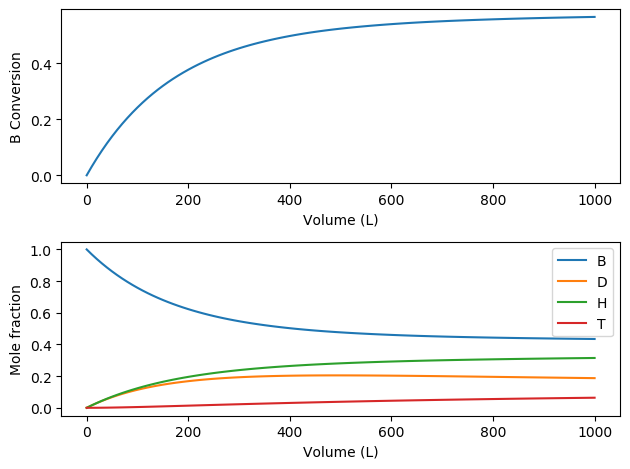

In [70]:
### 1. Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

### 2. Specify known values
T  = 1033     # K
Vr = 1000    # cm^3 , first just try this
P  = 1       # atm
Rg = 0.082507 # L atm / mol K

A = ['B','D','H','T']

F0 = [60*10**3,0,0,0]

k1 = 7 * 10**5 # L / mol hr
k2 = 4 * 10**5 # L / mol hr

KC1 = 0.31
KC2 = 0.48

### 3. Initial conditions and integration span
U0 = F0
tlim = [0,Vr]
tlist = np.linspace(tlim[0],tlim[1],101)

### 4. Differential equations
def diff(t,U):

    F = U
    
    C = P / Rg / T * F / np.sum(F)
    
    r1 = k1 * (C[0]**2-C[1]*C[2]/KC1)
    r2 = k2 * (C[0]*C[1]-C[3]*C[2]/KC2)
    
    R = np.zeros(len(U))
    
    R[0] = -2*r1 - r2
    R[1] =    r1 - r2
    R[2] =    r1 + r2
    R[3] =         r2
    
    dF = R
    
    dU = dF
    
    return dU

### 5. Integrate
soln = solve_ivp(diff,tlim,U0,t_eval=tlist)

### 6. Extract and use data
F = soln.y
V = soln.t

X = (F0[0]-F[0])/F0[0]

print('Conversion =',X[-1],'at V =',V[-1],'L')

fig = plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.plot(V,X)
ax1.set_xlabel('Volume (L)')
ax1.set_ylabel('B Conversion')

y = F/np.sum(F,0)

ax2.plot(V,y[0,:])
ax2.plot(V,y[1,:])
ax2.plot(V,y[2,:])
ax2.plot(V,y[3,:])
ax2.legend(['B','D','H','T'])
ax2.set_xlabel('Volume (L)')
ax2.set_ylabel('Mole fraction')

plt.tight_layout()
plt.show()

## Advanced version

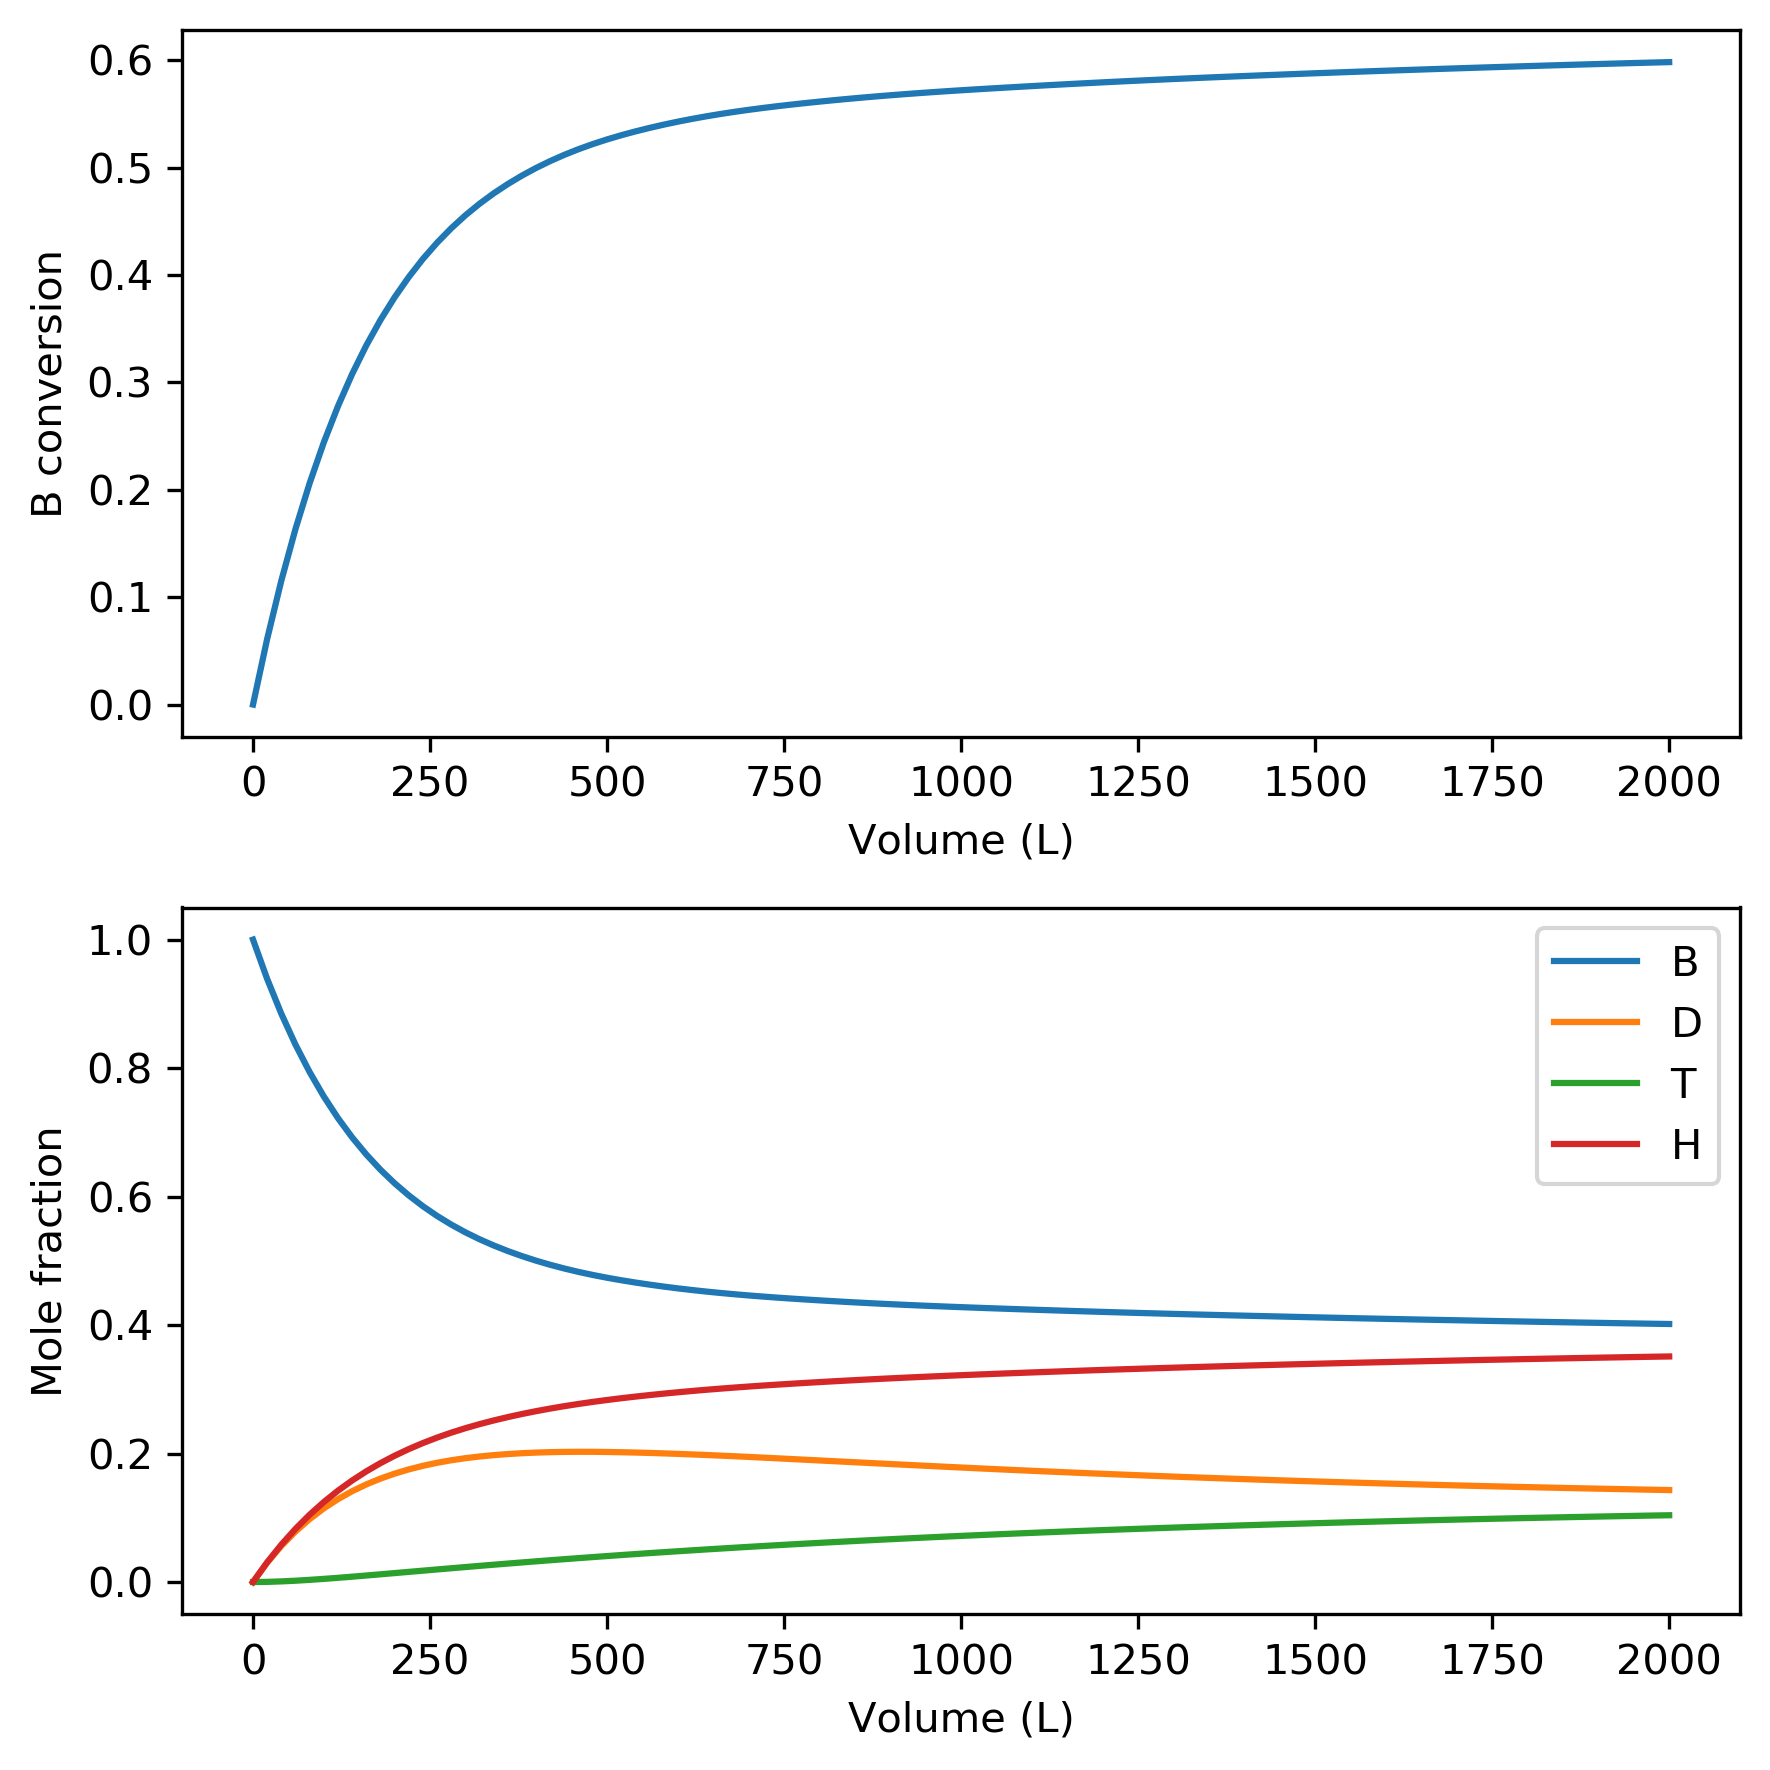

In [5]:
########## PFR simulation ##########

### Reset variables
%reset -f

### 1. Import packages
import numpy as np                  
import matplotlib.pyplot as plt     
from scipy.integrate import solve_ivp
import pandas as pd

### 2. Specify known values
T0  = 1033   # K
Vr  = 2000   # cm^3 
P0  =  1     # atm
Rg  = 0.082057 # L atm / mol K
Z0  = 1

A  = ['B','D','H','T']

IDN = pd.DataFrame(data=np.arange(0,len(A)),index=A,columns={'IDN'})
IDN = IDN['IDN']

F0 = [60*10**3,0,0,0]

nu = np.array([[-2, 1, 1, 0],
               [-1,-1, 1, 1]])

v0 = np.sum(F0) * Rg * T0 / P0

k1 = 7 * 10**5  # L / mol hr
k2 = 4 * 10**5  # L / mol hr

KC1 = 0.31
KC2 = 0.48

### 3. Initial conditions + integration limits
U0 = F0
tlim = (0,Vr)
tlist = np.linspace(tlim[0],tlim[1],num=101)

### 4. Differential equations
def diff(t,U):
    
    ### Redefine inputs
    F = U

    ### Initial calculations
    P = P0
    T = T0
    Z = Z0
    v = v0 * np.sum(F)/np.sum(F0)
    C = F / v
    
    ### Reaction rates    
    r=np.zeros((2,1))
    
    r[0] = k1*(C[IDN['B']]**2-C[IDN['D']]*C[IDN['H']]/KC1)
    r[1] = k2*(C[IDN['B']]*C[IDN['D']]-C[IDN['T']]*C[IDN['H']])

    ### Production rates
    R = np.dot(nu.T,r)
    
    ### Material balances
    dF = R
    
    ### Differential equations
    dU = np.zeros(len(U))
    dU = dF

    # Reorganize list to fit required dimensions 
    dU = dU[:,0]
    
    return dU

### 5. Run integration
soln = solve_ivp(diff,tlim,U0,t_eval=tlist)

### 6. Use output data
V = soln.t
F = soln.y

X_C6H6 = (F0[IDN['B']]-F[IDN['B']])/(F0[IDN['B']])
y = F/np.sum(F,0)

# Plot data
fig = plt.figure(figsize=(6,6),dpi=300)
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.plot(V,X_C6H6)
ax1.set_xlabel('Volume (L)')
ax1.set_ylabel('B conversion')

ax2.plot(V,y[IDN['B'],:])
ax2.plot(V,y[IDN['D'],:])
ax2.plot(V,y[IDN['T'],:])
ax2.plot(V,y[IDN['H'],:])
ax2.legend(['B','D','T','H'])
ax2.set_xlabel('Volume (L)')
ax2.set_ylabel('Mole fraction')

fig.tight_layout()
plt.show()

fig.savefig('figure.png')

In [4]:
import numpy as np

print(np.arange(0,len(A)))

[0 1 2 3]
